In [20]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch
import copy
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.models.GSNN import GSNN

from sklearn.metrics import r2_score

from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from gsnn.optim.OutputEdgeInferer import OutputEdgeInferer

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inferring output edges 



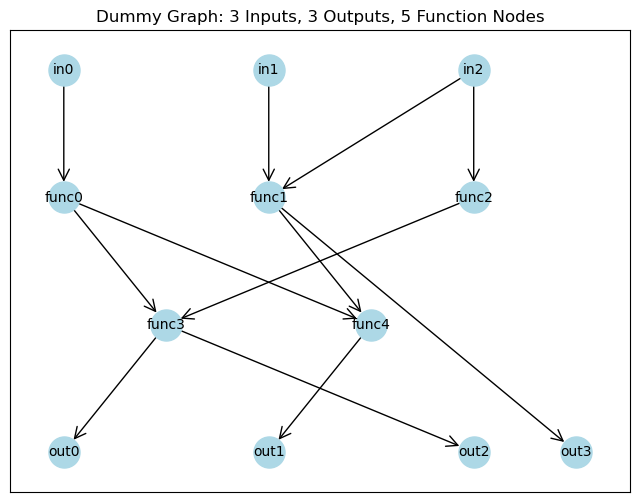

In [21]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2', 'out3']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2'), ('in2', 'func1')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3'), ('func0', 'func4')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2'), ('func1', 'out3')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1), 
    'out3': (3, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [22]:

special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=100, n_test=100, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.15)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)


In [23]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# simulate a missing edge (in2, func1)
edge_index_dict_TRUE = copy.deepcopy(data.edge_index_dict)


# remove edges func1 to out3
#remove = ('func1', 'out3')
remove = [('func4', 'out1'), ('func3', 'out2'), ('func1', 'out3')]
for edge in remove:
    src, dst = data.edge_index_dict['function', 'to', 'output'].clone()
    mask = ~((src == data.node_names_dict['function'].index(edge[0])) & (dst == data.node_names_dict['output'].index(edge[1])))
    data.edge_index_dict['function', 'to', 'output'] = data.edge_index_dict['function', 'to', 'output'][:, mask]

data.edge_index_dict['function', 'to', 'output']

tensor([[3],
        [0]])

In [24]:
model_kwargs = {'channels': 3, 
                'layers': 5, 
                'share_layers': False, 
                'bias': True, 
                'add_function_self_edges': True, 
                'norm': 'layer', 
                'dropout': 0.,
                'nonlin': torch.nn.ELU}

In [25]:
# train GSNN with a missing input edge  

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **model_kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

model = model.eval() 
with torch.inference_mode():    
    yhat_test = model(x_test)
loss_test = crit(y_test, yhat_test)
r2_test = r2_score(y_test.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
print(f'test loss: {loss_test.item():.3f} | test r2: {r2_test:.3f}')


n params 6320
test loss: 0.802 | test r2: 0.193


Fitting OutputEdgeInferer on cpu...
# parameters:  300
epoch 0 loss: 6.592256784439087592]
epoch 1 loss: 3.7812628746032715125]
epoch 2 loss: 2.2843069434165955716]
epoch 3 loss: 1.4881707131862644565]
epoch 4 loss: 1.1564314365386963158]
epoch 5 loss: 1.0034881234169006227]
epoch 6 loss: 0.9189485013484955614]
epoch 7 loss: 0.8438188582658768258]
epoch 8 loss: 0.7607485800981522481]
epoch 9 loss: 0.689739748835563798]]
epoch 10 loss: 0.634756892919540457]
epoch 11 loss: 0.6025913581252098326]
epoch 12 loss: 0.580315738916397137]
epoch 13 loss: 0.565174296498298624]
epoch 14 loss: 0.551893420517444689]
epoch 15 loss: 0.537574887275695849]]
epoch 16 loss: 0.528227806091308661]]
epoch 17 loss: 0.521082691848278463]
epoch 18 loss: 0.5133229866623878557]
epoch 19 loss: 0.507903024554252647]
epoch 20 loss: 0.5013037398457527794]
epoch 21 loss: 0.49570398777723316]]]
epoch 22 loss: 0.49268320947885513]5]
epoch 23 loss: 0.487835124135017447]]
epoch 24 loss: 0.483576752245426203]
epoch 25 loss

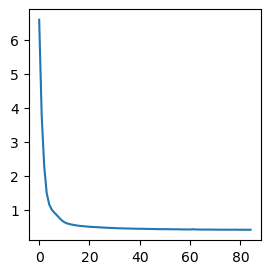

In [26]:
OEI = OutputEdgeInferer(data, 
                         model.channels*model.layers, 
                         lr=1e-2, 
                         wd=0, 
                         epochs=2000, 
                         use_batchnorm=False,
                         bn_affine=False,
                         tol=1e-4,
                         patience=5,
                         agg='all')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=10, shuffle=True)
losses = OEI.fit(train_loader, model)

plt.figure(figsize=(3,3))
plt.plot(losses)
plt.show()

In [27]:
res = OEI.evaluate(test_loader, model.eval())
res.sort_values(by='q_value', ascending=True)

Evaluating OutputEdgeInferer on cpu...


/home/teddy/local/GSNN/gsnn/optim/OutputEdgeInferer.py:358: RuntimeWarning: invalid value encountered in divide
  model_cov_xy / np.sqrt(model_var_x * model_var_y),


,func_node,output_node,mse,r2,r,has_edge,p_value,model_r2,model_r,model_mse,r2_gain,r_gain,mse_gain,q_value,within_output_rank
0,func1,out3,0.185279,0.823894,0.919120,False,2.086947e-11,0.00000,0.00000,1.120165,0.823894,0.919120,-0.934886,4.173895e-10,1
1,func3,out2,0.047971,0.948791,0.974521,False,2.940781e-09,0.00000,0.00000,0.958270,0.948791,0.974521,-0.910299,2.940781e-08,1
2,func4,out2,0.121563,0.870232,0.933362,False,4.913948e-09,0.00000,0.00000,0.958270,0.870232,0.933362,-0.836707,3.275965e-08,2
3,func4,out1,0.369538,0.628792,0.815660,False,3.834745e-08,0.00000,0.00000,1.084873,0.628792,0.815660,-0.715335,1.917373e-07,1
4,func1,out1,0.448407,0.549566,0.753065,False,1.199566e-07,0.00000,0.00000,1.084873,0.549566,0.753065,-0.636466,4.798264e-07,2
5,func3,out1,0.445066,0.552922,0.767172,False,2.191132e-06,0.00000,0.00000,1.084873,0.552922,0.767172,-0.639807,7.303773e-06,3
6,func0,out2,0.425644,0.545625,0.738807,False,1.920007e-05,0.00000,0.00000,0.958270,0.545625,0.738807,-0.532625,5.485734e-05,3
7,func4,out3,0.678931,0.354680,0.629966,False,3.609376e-05,0.00000,0.00000,1.120165,0.354680,0.629966,-0.441234,9.023440e-05,2
8,func2,out2,0.484007,0.483323,0.701398,False,1.499416e-04,0.00000,0.00000,0.958270,0.483323,0.701398,-0.474262,2.884546e-04,4
9,func1,out2,0.505211,0.460688,0.685677,False,1.389110e-04,0.00000,0.00000,0.958270,0.460688,0.685677,-0.453059,2.884546e-04,5


In [ ]:
res_missing = res[lambda x: (x.within_output_rank == 1) & (x.has_edge == False)]
res_missing_edges = [(i,j) for i,j in res_missing[['func_node', 'output_node']].values]

res_missing_edges # inferred edges 

[('func1', 'out3'), ('func3', 'out2'), ('func4', 'out1')]

In [ ]:
remove # true removed 

[('func4', 'out1'), ('func3', 'out2'), ('func1', 'out3')]